# Анализ результатов АБ-теста

В данном задании вам нужно будет

* проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса

* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами

* определить характер этих изменений и практическую значимость вводимого изменения

* понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pylab

In [4]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Описание  данных:
* userID:  уникальный идентификатор пользователя

* browser:  браузер, который использовал userID

* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)

* n_clicks: количество кликов, которые пользоваль совершил за n_queries

* n_queries: количество запросов, который совершил userID, пользуясь браузером browser

* n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.




Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

## #1

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [5]:
frac = (data[data.slot == 'exp'].n_clicks.sum() /  data[data.slot == 'control'].n_clicks.sum() - 1) * 100
np.round(frac, 3)

1.614

## #2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [6]:
exp_group = data[data.slot == 'exp']
ctrl_group = data[data.slot == 'control']

In [7]:
def get_bootstrap_samples(data, n_samples):
  indices = np.random.randint(0, len(data), (n_samples, len(data)))
  samples = data[indices]
  return samples

In [8]:
def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
  return boundaries

In [9]:
exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_group.n_clicks.values, 1000)))
ctrl_median_scores = list(map(np.median, get_bootstrap_samples(ctrl_group.n_clicks.values, 1000)))

In [10]:
exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_group.n_clicks.values, 1000)))
ctrl_mean_scores = list(map(np.mean, get_bootstrap_samples(ctrl_group.n_clicks.values, 1000)))

In [11]:
print("95% confidence interval for the experiment median:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for the control median:",  stat_intervals(ctrl_median_scores, 0.05))
print("95% confidence interval for the experiment mean:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for the control mean:",  stat_intervals(ctrl_mean_scores, 0.05))

95% confidence interval for the experiment median: [5. 5.]
95% confidence interval for the control median: [4. 4.]
95% confidence interval for the experiment mean: [11.50755735 11.65810782]
95% confidence interval for the control mean: [11.20596732 11.35575523]


In [12]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(exp_median_scores, ctrl_median_scores)))
delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(exp_mean_scores, ctrl_mean_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))
print("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [1. 1.]
95% confidence interval for the difference between means [0.19793946 0.41272135]


## #3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 

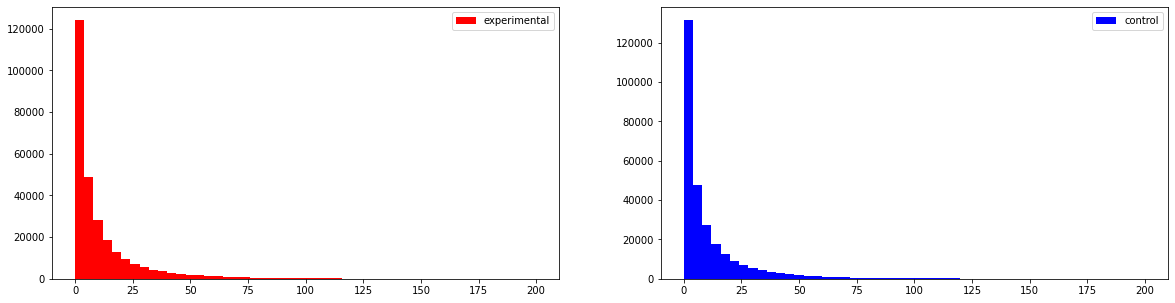

In [13]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.hist(exp_group.n_clicks, label = 'experimental', color = 'r', bins = 50, range = (0, 200))
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(ctrl_group.n_clicks, label = 'control', color = 'b', bins = 50, range = (0, 200))
plt.legend()

plt.show()

# #4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. 

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных. 

Для простоты рассмотрим одновыборочный t-критерий.  Его статистика имеет вид   \frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}  
S 
2
 /n
​
 
X
ˉ
 −μ
​
 , то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯  —  среднее значение в выборке — было распределено нормально N(μ,σ2n)
nσ2S2  — несмещенная оценка дисперсии c масштабирующим коэффициентом —  была распределена по хи-квадрат  c n−1 степенями свободы  χ2(n−1) 

Простое доказательство необходимости и достаточности этого требования  можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого 

 Получите из данных n_boot_samples  псевдовыборок. 

По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared) 

Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения с помощью команды 

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [23]:
np.random.seed(0)
n_boot_samples = 500

boot_samples = get_bootstrap_samples(ctrl_group.n_clicks.values, n_boot_samples)

means = [np.mean(x) for x in boot_samples]
squares = [np.sum((x - np.mean(x)) ** 2) for x in boot_samples]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


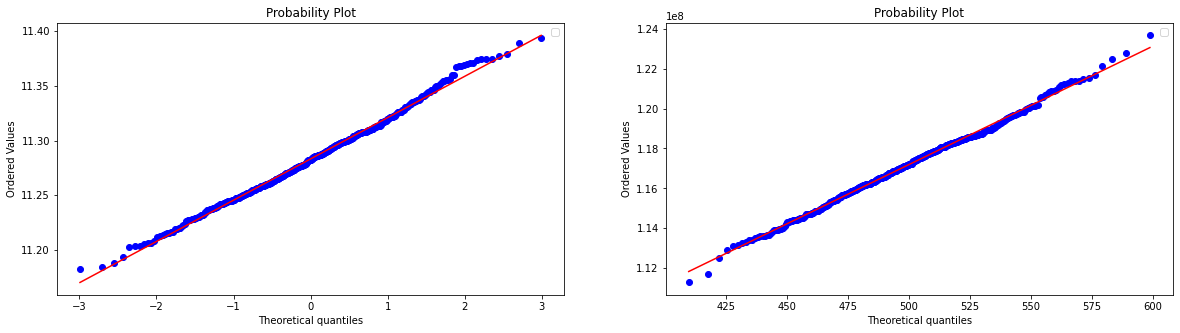

In [26]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
R2_mean = sts.probplot(means, dist="norm", plot=plt)
plt.legend()

plt.subplot(1, 2, 2)
R2_sq = sts.probplot(squares, dist = sts.distributions.chi2, sparams = (n_boot_samples-1), plot=plt)
plt.legend()

plt.show()

In [33]:
print("R2_mean = %f" %(R2_mean[1][2] ** 2))
print("R2_square = %f" %(R2_sq[1][2] ** 2))

R2_mean = 0.995954
R2_square = 0.997285


# #5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [42]:
ctrl_mann = ctrl_group.groupby('userID').sum().n_clicks
exp_mann = exp_group.groupby('userID').sum().n_clicks

In [44]:
print(ctrl_mann.mean())
print(exp_mann.mean())

11.287332273762974
11.589351572215314


In [48]:
print(len(ctrl_mann), len(ctrl_mann.unique()))
print(len(exp_mann), len(exp_mann.unique()))

284392 332
281450 330


In [43]:
sts.mannwhitneyu(exp_mann, ctrl_mann)

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

# #6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с \alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [77]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [70]:
p_values = {}
n1 = len(ctrl_group.browser.unique())
n2 = len(exp_group.browser.unique())
print(n1, n2)

6 6


In [79]:
for i in range(n1):
    browser = ctrl_group.browser.unique()[i]
    ctrl_mann = ctrl_group[ctrl_group.browser == browser].n_clicks
    exp_mann = exp_group[exp_group.browser == browser].n_clicks
    p_values[browser] = sts.mannwhitneyu(exp_mann, ctrl_mann)[1]

p_values

{'Browser #14': 0.0,
 'Browser #17': 0.07480120286021603,
 'Browser #2': 0.0544877208394482,
 'Browser #20': 0.9073331277747075,
 'Browser #22': 0.5148110304420064,
 'Browser #4': 0.8152123531690997}

In [82]:
rejected, p_corrected, _, _ = multipletests(list(p_values.values()), alpha = 0.05, method = 'holm')
print(rejected)
print(p_corrected)

[ True False False False False False]
[0.         0.29920481 0.2724386  1.         1.         1.        ]


# #7

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [88]:
browser_rates_ctrl = {}
browser_rates_exp = {}

for i in range(n1):
    ctrl_grouped = ctrl_group.groupby('browser').sum()
    exp_grouped = exp_group.groupby('browser').sum()

    browser = ctrl_grouped.index[i]

    browser_rates_ctrl[browser] = np.round(ctrl_grouped.n_nonclk_queries[i] / ctrl_grouped.n_queries[i], 3)
    browser_rates_exp[browser] = np.round(exp_grouped.n_nonclk_queries[i] / exp_grouped.n_queries[i], 3)

print(browser_rates_exp)
print(browser_rates_ctrl)

{'Browser #14': 0.438, 'Browser #17': 0.369, 'Browser #2': 0.45, 'Browser #20': 0.39, 'Browser #22': 0.399, 'Browser #4': 0.451}
{'Browser #14': 0.576, 'Browser #17': 0.363, 'Browser #2': 0.46, 'Browser #20': 0.405, 'Browser #22': 0.406, 'Browser #4': 0.47}
